# Model v19_attention

Path images, roughness metric = 1 second ahead, k-means 4, data split within sessions, images with attention region.

## Set-up

In [1]:
!pip install wandb

     |████████████████████████████████| 1.8MB 12.9MB/s 
     |████████████████████████████████| 81kB 12.3MB/s 
     |████████████████████████████████| 163kB 53.9MB/s 
     |████████████████████████████████| 102kB 14.3MB/s 
     |████████████████████████████████| 133kB 54.0MB/s 
     |████████████████████████████████| 71kB 12.2MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6490 sha256=ea7827d7203f0c7263e2d88b4a2bef2aa597df2383bd14354e753387f5e97cc9
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built subprocess32


In [2]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 51.4MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
from fastai.vision import *
import pandas as pd
import numpy as np
import os

In [5]:
import wandb
from wandb.fastai import WandbCallback

wandb.init(project='roughness-classifier-4')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Model

#### Load data

In [7]:
path = '/gdrive/My Drive/Labeling/Model'
folder_path = os.path.join(path, 'attention_region', 'v19')
image_path = '/gdrive/My Drive/Labeling/Segmentation/Predictions/AttentionRegion/0'
label_path = '/gdrive/My Drive/Labeling/LabelsCSV'

In [8]:
df = pd.read_csv(os.path.join(label_path, 'attention_region', 'labels_path_validated_mask_split_metric_2.csv'))
df = df.filter(items=['image_mask', 'group_4', 'dataset'])

# Categorical data
df['group_4'] = df['group_4'].astype(int).astype(str)

# Create is_valid column
df['is_valid'] = df['dataset'] == 'valid'

# Training set, filter out dataset column
train = df[df['dataset'] == 'train'].filter(items=['image_mask', 'group_4', 'is_valid'])

# Validation set, filter out dataset column
valid = df[df['dataset'] == 'valid'].filter(items=['image_mask', 'group_4', 'is_valid'])

#### Balance classes

In [9]:
# Training set
group_0 = train[train['group_4'] == '0']
group_1 = train[train['group_4'] == '1']
group_2 = train[train['group_4'] == '2']
group_3 = train[train['group_4'] == '3']

print(len(group_0))
print(len(group_1))
print(len(group_2))
print(len(group_3))

1648
1267
529
145


In [10]:
group_0 = group_0[:1000]
group_1 = group_1[:1000]

train_balanced = group_0.append(group_1).append(group_2).append(group_3)

print(len(train_balanced))
print(len(train_balanced[train_balanced['group_4'] == '0']))
print(len(train_balanced[train_balanced['group_4'] == '1']))
print(len(train_balanced[train_balanced['group_4'] == '2']))
print(len(train_balanced[train_balanced['group_4'] == '3']))

2674
1000
1000
529
145


Balanced training set composition:
- 0: 37.40%
- 1: 37.40%
- 2: 19.78%
- 3: 5.42%

Validation set:
- 0: 298/797 = 37.40%
- 1: 298/797 = 37.40%
- 2: 150/797: 18.82%
- 3: 50/797 = 6.27%

In [11]:
# Validation set
group_0_v = valid[valid['group_4'] == '0']
group_1_v = valid[valid['group_4'] == '1']
group_2_v = valid[valid['group_4'] == '2']
group_3_v = valid[valid['group_4'] == '3']

print(len(group_0_v))
print(len(group_1_v))
print(len(group_2_v))
print(len(group_3_v))

366
333
150
51


In [12]:
group_0_v = group_0_v[:298]
group_1_v = group_1_v[:298]

valid_balanced = group_0_v.append(group_1_v).append(group_2_v).append(group_3_v)

print(len(valid_balanced))
print(len(valid_balanced[valid_balanced['group_4'] == '0']))
print(len(valid_balanced[valid_balanced['group_4'] == '1']))
print(len(valid_balanced[valid_balanced['group_4'] == '2']))
print(len(valid_balanced[valid_balanced['group_4'] == '3']))

797
298
298
150
51


In [13]:
df_balanced = train_balanced.append(valid_balanced)
print(len(df_balanced))
print(len(df_balanced[df_balanced['is_valid'] == False]))
print(len(df_balanced[df_balanced['is_valid'] == True]))

3471
2674
797


In [14]:
df_balanced.head()

,image_mask,group_4,is_valid
0,969905035s184ms.png,0,False
1,970588340s260ms.png,0,False
5,969902113s258ms.png,0,False
6,970588196s250ms.png,0,False
7,970588218s272ms.png,0,False


#### DataBunch

The original image size is 3840 x 2160. We resize (squish) to a smaller image with the same aspect ratio (270 x 480, decreased by a factor of 8) [Link](https://fastai1.fast.ai/vision.transform.html#Data-augmentation-details).

In [15]:
bs = 64

In [17]:
np.random.seed(42)
data = (ImageList
        .from_df(path=image_path, df=df_balanced)
        .split_from_df(col='is_valid')
        .label_from_df(cols='group_4')
        .transform(get_transforms(do_flip=False), size=(270,480))
        .databunch(bs=bs)
        .normalize())

In [18]:
train_x = data.train_ds.x
train_y = data.train_ds.y
valid_x = data.valid_ds.x
valid_y = data.valid_ds.y

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

2674 2674
797 797


In [19]:
print(data.classes)

['0', '1', '2', '3']


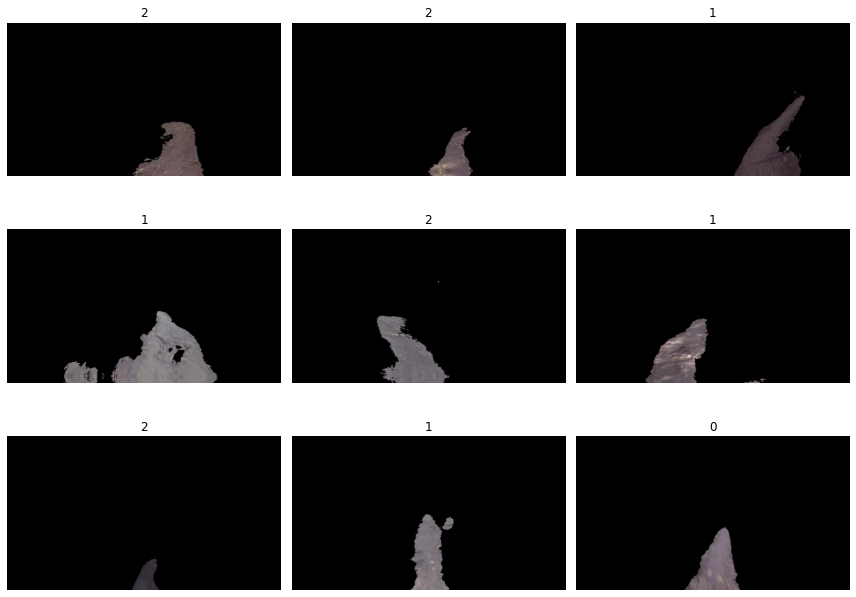

In [20]:
data.show_batch(rows=3, figsize=(12,9))

#### ResNet50

In [21]:
arch = models.resnet50
learn = cnn_learner(data, arch, metrics=[accuracy], callback_fns=WandbCallback)
# learn = cnn_learner(data, arch, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


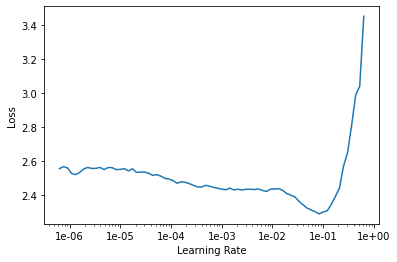

In [23]:
learn.recorder.plot()

In [24]:
lr = 0.01

In [25]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,2.271201,2.100458,0.367629,13:44
1,1.770772,1.437607,0.314931,11:11
2,1.614735,1.500253,0.340025,11:10
3,1.491958,1.457175,0.342535,11:11
4,1.362144,1.298655,0.387704,11:11


Better model found at epoch 0 with valid_loss value: 2.1004576683044434.
Better model found at epoch 1 with valid_loss value: 1.4376074075698853.
Better model found at epoch 4 with valid_loss value: 1.298654556274414.
Loaded best saved model from /content/wandb/run-20210107_193237-2nil7ooz/files/bestmodel.pth


In [26]:
learn.save(os.path.join(folder_path, 'v19-attention-stage-1'))

In [27]:
learn.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.315541,1.711859,0.326223,11:20
1,1.324661,1.418549,0.367629,11:13


Better model found at epoch 0 with valid_loss value: 1.7118587493896484.
Better model found at epoch 1 with valid_loss value: 1.4185491800308228.
Loaded best saved model from /content/wandb/run-20210107_193237-2nil7ooz/files/bestmodel.pth


In [ ]:
learn.load(os.path.join(folder_path, 'v19-attention-stage-1'))

In [29]:
interp = ClassificationInterpretation.from_learner(learn)

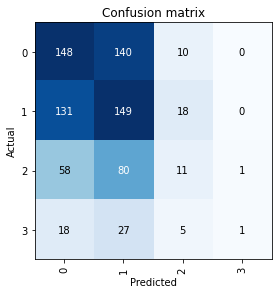

In [30]:
interp.plot_confusion_matrix()

#### Fine-tune

In [ ]:
learn.load(os.path.join(folder_path, 'v19-attention-stage-1'))

In [32]:
learn.data.batch_size = 16

In [33]:
learn.data.batch_size

16

In [34]:
learn.unfreeze()

In [35]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


Loaded best saved model from /content/wandb/run-20210107_193237-2nil7ooz/files/bestmodel.pth
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


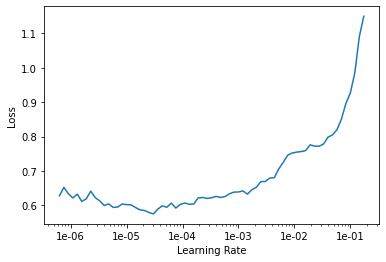

In [ ]:
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.263707,1.301193,0.402760,11:17
1,1.244208,1.274186,0.406524,11:12
2,1.251685,1.267079,0.404015,11:11
3,1.218616,1.281652,0.385194,11:06
4,1.191851,1.253700,0.383940,10:52


Better model found at epoch 0 with valid_loss value: 1.3011927604675293.
Better model found at epoch 1 with valid_loss value: 1.2741862535476685.
Better model found at epoch 2 with valid_loss value: 1.2670791149139404.
Better model found at epoch 4 with valid_loss value: 1.2536998987197876.
Loaded best saved model from /content/wandb/run-20210107_193237-2nil7ooz/files/bestmodel.pth


In [37]:
learn.save(os.path.join(folder_path, 'v19-attention-stage-2'))

In [43]:
learn.fit_one_cycle(2, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.176789,1.256926,0.391468,11:11
1,1.187097,1.259311,0.368883,11:02


Better model found at epoch 0 with valid_loss value: 1.2569262981414795.
Loaded best saved model from /content/wandb/run-20210107_193237-2nil7ooz/files/bestmodel.pth


In [ ]:
learn.load(os.path.join(folder_path, 'v19-attention-stage-2'))

In [38]:
learn.freeze()

In [39]:
interp = ClassificationInterpretation.from_learner(learn)

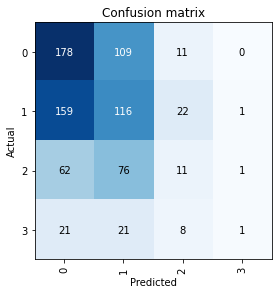

In [40]:
interp.plot_confusion_matrix()

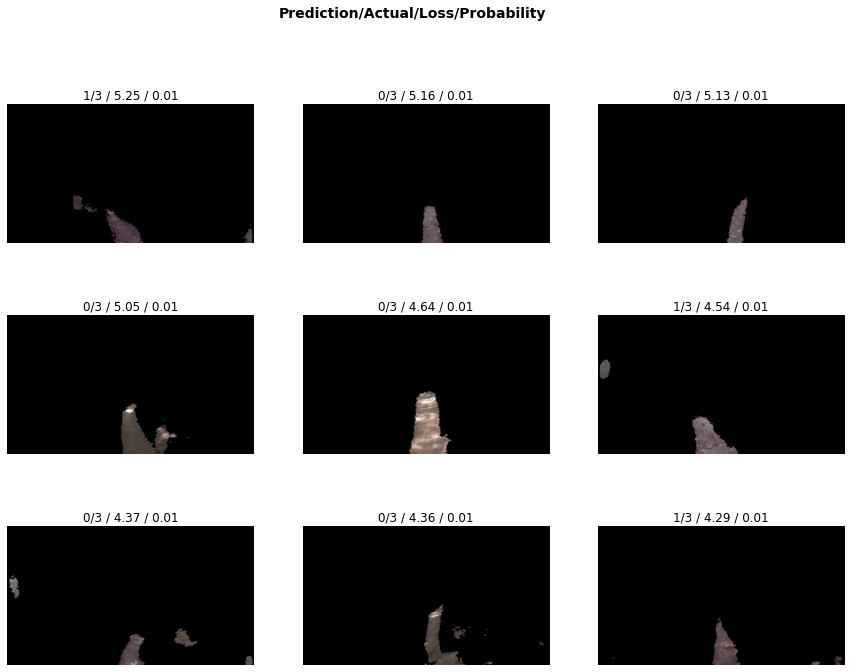

In [41]:
interp.plot_top_losses(9, figsize=(15,11))